## Burger's Equation
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in [-1,1],\ t\in(0,1] 
\end{equation}
We set $\nu=0.1/\pi$ and consider the periodic boundary condition here, i.e.:
$$
u(-1, t) = u(1, t),\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

## (2) The Deep Generative Neural Operator (DGNO)

### (2.1) Prepare data

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 10086 
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Burgers_1d'
tag = 'tanhBeta64'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/Burgers_1d/viscid_train.mat', 'r')
data_test = h5py.File('../../Problems/Burgers_1d/viscid_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["u0"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["u_sol"][...,n0:n0+ndata]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np.array(data['x_mesh']).T
    t_mesh = np.array(data['t_mesh']).T
    X, T = np.meshgrid(x_mesh, t_mesh)
    mesh = np2tensor(np.vstack([X.ravel(), T.ravel()]).T, dtype)
    grid_xt = mesh.reshape(-1, 2)
    #
    x = np2tensor(x_mesh).reshape(1, -1, 1).repeat(ndata,1,1)
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, u, uT, x, grid_xt
#
a_train, u_train, uT_train, x_train, gridxt_train = get_data(data_train, n_train, dtype)
a_test, u_test, uT_test, x_test, gridxt_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of gridxt_train:', gridxt_train.shape)
#
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridxt_test:', gridxt_test.shape)
######################################
# Generate training data
######################################
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
#### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=1, nt=5000, Rmax=1e-4, Rmin=1e-4, method='hypercube')
#### (initial points)
xt_init = pointGen.init_point(num_sample=a_test.shape[1], t_stamp=[0.], method='mesh')
#### (initial points)
xt_end = pointGen.init_point(num_sample=uT_test.shape[1], t_stamp=[1.], method='mesh')
#### (boundary points)
xt_lb, xt_ub = pointGen.boundary_point(num_sample=500)

<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
The shape of x_train: torch.Size([1000, 128, 1])
The shape of a_train: torch.Size([1000, 128, 1])
The shape of u_train: torch.Size([1000, 12928, 1])
The shape of uT_train: torch.Size([1000, 128, 1])
The shape of gridxt_train: torch.Size([12928, 2])
The shape of x_test: torch.Size([200, 128, 1])
The shape of a_test: torch.Size([200, 128, 1])
The shape of u_test: torch.Size([200, 12928, 1])
The shape of uT_train: torch.Size([200, 128, 1])
The shape of gridxt_test: torch.Size([12928, 2])


### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=10, dataType=dtype).get_testFun()
print('The shape of int_grid', int_grid.shape, 'The shape of phi:', phi.shape)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, xt):
        x= xt[...,0:1]
        u = u * torch.sin(np.pi*x/2. + np.pi/2.)
        return u

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        ######################## 
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        
    def Loss_pde(self, a_batch, w_pde, nc=100, lamda=0.1/torch.pi):
        beta = self.model_enc(a_batch)
        #
        if w_pde>0.:
            n_batch = a_batch.shape[0]
            # ################################## 
            xc, tc, R = pointGen.weight_centers(n_center=1, nt=nc, Rmax=1e-4, Rmin=1e-4, method='hypercube')
            xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
            # 
            x = (self.int_grid * R + xc).reshape(-1, 1)
            t = tc.repeat(1, self.n_grid, 1).reshape(-1, 1)
            #
            x = Variable(x.repeat((n_batch,1,1)), requires_grad=True) 
            t = Variable(t.repeat((n_batch,1,1)), requires_grad=True)  
            xt = torch.cat([x,t], dim=-1)
            ##########################################
            v = self.v.repeat((nc,1,1)).reshape(-1,1)
            dv = (self.dv_dr / R).reshape(-1,1)
            ##########################################
            u = self.model_u(xt, beta)
            u = self.mollifer(u, xt)
            du = grad(inputs=xt, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            dux, dut = du[...,0:1], du[...,1:2]
            ########################################### weawk form
            res0 = dut*v + u * dux * v + lamda * dux * dv
            res0 = torch.mean(res0.reshape(n_batch, nc, self.n_grid), dim=-1)
            ################################################
            res_sq = (res0)**2
            res_sq, indices = torch.sort(res_sq.flatten(), descending=True, dim=0)

            return self.solver.getLoss(res0, torch.zeros_like(res0)) + torch.sum( res_sq[0:100*25] )  
        else:
            return torch.tensor(0.)

    def Loss_data(self, x, a, u, w_data):
        n_batch = a.shape[0]
        ############### The initial condition
        xt = xt_init.repeat(n_batch, 1, 1).to(self.device)
        beta = self.model_enc(a)
        u_init = self.model_u(xt, beta)
        u_init = self.mollifer(u_init, xt)
        #
        loss_init = self.solver.getLoss(u_init, a)
        
        return loss_init
        
    def Error(self, x, a, u):
        n_batch = a.shape[0]
        ##################
        xt = gridxt_test.repeat(n_batch, 1, 1).to(self.device)
        beta = self.model_enc(a)
        u_all = self.model_u(xt, beta)
        u_all = self.mollifer(u_all, xt)
        #
        error = self.solver.getError(u_all, u)

        return error

######################################
# Setups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' # for u model
beta_size = 64     
# ####################################### 
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(Encoder, self).__init__()
        self.beta_net = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, x):
        beta = nn.Tanh()(self.beta_net(x))
        
        return beta
        
layers_beta = [a_train.shape[1], 128, 128, 64, 64, beta_size]
model_enc = Encoder(layers_beta, act_beta='ELU', dtype=dtype).to(device)
###################################### The u model (MultiONet)
hidden_list, act_x, act_a = [80]*6, 'Tanh_Sin', 'Tanh_Sin'
model_u = solver.getModel(x_in_size=2, a_in_size=beta_size, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)
# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
########
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

The shape of int_grid torch.Size([10, 1]) The shape of phi: torch.Size([10, 1])
49,600 training parameters.
83,212 training parameters.
132,812 total parameters


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=1/3, step_size=2000)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=5000, w_pde=500., batch_size=50, epochs=10000, epoch_show=50,
             **{'save_path':f'saved_models/DGNO_{tag}/'})

  0%|▍                                                                            | 50/10000 [00:22<1:13:45,  2.25it/s]

Epoch:50 Time:22.7190, loss:5459.4844, loss_pde:2.2778, loss_data:0.8641
                l2_test:0.1529, lr:0.001


  1%|▊                                                                           | 100/10000 [00:44<1:12:02,  2.29it/s]

Epoch:100 Time:44.8652, loss:4630.4824, loss_pde:2.2152, loss_data:0.7046
                l2_test:0.1232, lr:0.001


  2%|█▏                                                                          | 150/10000 [01:06<1:11:31,  2.30it/s]

Epoch:150 Time:66.7832, loss:3980.2320, loss_pde:2.1160, loss_data:0.5844
                l2_test:0.1081, lr:0.001


  2%|█▌                                                                          | 200/10000 [01:28<1:11:47,  2.27it/s]

Epoch:200 Time:88.7245, loss:3952.5844, loss_pde:2.1740, loss_data:0.5731
                l2_test:0.1392, lr:0.001


  2%|█▉                                                                          | 250/10000 [01:51<1:13:14,  2.22it/s]

Epoch:250 Time:111.1534, loss:3209.1945, loss_pde:1.6271, loss_data:0.4791
                l2_test:0.0890, lr:0.001


  3%|██▎                                                                         | 300/10000 [02:13<1:11:24,  2.26it/s]

Epoch:300 Time:133.5270, loss:3148.1578, loss_pde:1.8383, loss_data:0.4458
                l2_test:0.0857, lr:0.001


  4%|██▋                                                                         | 350/10000 [02:35<1:11:10,  2.26it/s]

Epoch:350 Time:155.6313, loss:3080.9332, loss_pde:1.6602, loss_data:0.4502
                l2_test:0.1130, lr:0.001


  4%|███                                                                         | 400/10000 [02:57<1:10:41,  2.26it/s]

Epoch:400 Time:177.8049, loss:2789.5246, loss_pde:1.5194, loss_data:0.4060
                l2_test:0.1177, lr:0.001


  4%|███▍                                                                        | 450/10000 [03:19<1:10:20,  2.26it/s]

Epoch:450 Time:199.9260, loss:2747.0215, loss_pde:1.6233, loss_data:0.3871
                l2_test:0.0987, lr:0.001


  5%|███▊                                                                        | 500/10000 [03:42<1:13:44,  2.15it/s]

Epoch:500 Time:222.2703, loss:3062.8885, loss_pde:1.9182, loss_data:0.4208
                l2_test:0.1148, lr:0.001


  6%|████▏                                                                       | 550/10000 [04:05<1:09:52,  2.25it/s]

Epoch:550 Time:245.3228, loss:2559.1602, loss_pde:1.6461, loss_data:0.3472
                l2_test:0.0950, lr:0.001


  6%|████▌                                                                       | 600/10000 [04:27<1:07:11,  2.33it/s]

Epoch:600 Time:267.5867, loss:2412.8635, loss_pde:1.5644, loss_data:0.3261
                l2_test:0.0684, lr:0.001


  6%|████▉                                                                       | 650/10000 [04:49<1:09:19,  2.25it/s]

Epoch:650 Time:289.6393, loss:2421.2074, loss_pde:1.4419, loss_data:0.3401
                l2_test:0.0632, lr:0.001


  7%|█████▎                                                                      | 700/10000 [05:11<1:08:19,  2.27it/s]

Epoch:700 Time:311.3457, loss:2417.6078, loss_pde:1.4227, loss_data:0.3412
                l2_test:0.0799, lr:0.001


  8%|█████▋                                                                      | 750/10000 [05:33<1:11:12,  2.16it/s]

Epoch:750 Time:333.6566, loss:2261.2273, loss_pde:1.3721, loss_data:0.3150
                l2_test:0.0695, lr:0.001


  8%|██████                                                                      | 800/10000 [05:56<1:10:07,  2.19it/s]

Epoch:800 Time:356.1779, loss:2355.9582, loss_pde:1.4619, loss_data:0.3250
                l2_test:0.0808, lr:0.001


  8%|██████▍                                                                     | 850/10000 [06:18<1:07:44,  2.25it/s]

Epoch:850 Time:378.7598, loss:2269.2965, loss_pde:1.4024, loss_data:0.3136
                l2_test:0.0686, lr:0.001


  9%|██████▊                                                                     | 900/10000 [06:41<1:07:23,  2.25it/s]

Epoch:900 Time:401.1205, loss:2035.5084, loss_pde:1.2263, loss_data:0.2845
                l2_test:0.0579, lr:0.001


 10%|███████▏                                                                    | 950/10000 [07:03<1:06:54,  2.25it/s]

Epoch:950 Time:423.3177, loss:2117.2637, loss_pde:1.2869, loss_data:0.2948
                l2_test:0.0670, lr:0.001


 10%|███████▌                                                                   | 1000/10000 [07:26<1:10:55,  2.12it/s]

Epoch:1000 Time:446.1748, loss:1924.0969, loss_pde:1.1639, loss_data:0.2684
                l2_test:0.0608, lr:0.001


 10%|███████▉                                                                   | 1050/10000 [07:48<1:06:01,  2.26it/s]

Epoch:1050 Time:468.9627, loss:2003.1400, loss_pde:1.2382, loss_data:0.2768
                l2_test:0.0639, lr:0.001


 11%|████████▎                                                                  | 1100/10000 [08:11<1:05:50,  2.25it/s]

Epoch:1100 Time:491.1577, loss:2081.3787, loss_pde:1.2932, loss_data:0.2870
                l2_test:0.0687, lr:0.001


 12%|████████▋                                                                  | 1150/10000 [08:34<1:07:05,  2.20it/s]

Epoch:1150 Time:514.1487, loss:2036.5992, loss_pde:1.3516, loss_data:0.2722
                l2_test:0.0791, lr:0.001


 12%|█████████                                                                  | 1200/10000 [08:56<1:05:11,  2.25it/s]

Epoch:1200 Time:536.4717, loss:1885.2676, loss_pde:1.2928, loss_data:0.2478
                l2_test:0.0532, lr:0.001


 12%|█████████▍                                                                 | 1250/10000 [09:18<1:05:05,  2.24it/s]

Epoch:1250 Time:558.8568, loss:2018.9604, loss_pde:1.4268, loss_data:0.2611
                l2_test:0.0582, lr:0.001


 13%|█████████▊                                                                 | 1300/10000 [09:41<1:04:22,  2.25it/s]

Epoch:1300 Time:581.1294, loss:1795.0256, loss_pde:1.1213, loss_data:0.2469
                l2_test:0.0527, lr:0.001


 14%|██████████▏                                                                | 1350/10000 [10:03<1:05:44,  2.19it/s]

Epoch:1350 Time:603.6782, loss:1942.5986, loss_pde:1.3941, loss_data:0.2491
                l2_test:0.0680, lr:0.001


 14%|██████████▌                                                                | 1400/10000 [10:26<1:04:17,  2.23it/s]

Epoch:1400 Time:626.0622, loss:1725.1707, loss_pde:1.1306, loss_data:0.2320
                l2_test:0.0531, lr:0.001


 14%|██████████▉                                                                | 1450/10000 [10:48<1:04:06,  2.22it/s]

Epoch:1450 Time:648.0701, loss:1715.8588, loss_pde:1.0476, loss_data:0.2384
                l2_test:0.0525, lr:0.001


 15%|███████████▎                                                               | 1500/10000 [11:10<1:00:15,  2.35it/s]

Epoch:1500 Time:670.9441, loss:1898.8859, loss_pde:1.2434, loss_data:0.2554
                l2_test:0.0636, lr:0.001


 16%|███████████▋                                                               | 1550/10000 [11:33<1:02:16,  2.26it/s]

Epoch:1550 Time:693.1206, loss:1645.7676, loss_pde:1.1113, loss_data:0.2180
                l2_test:0.0498, lr:0.001


 16%|████████████                                                               | 1600/10000 [11:55<1:05:57,  2.12it/s]

Epoch:1600 Time:715.4737, loss:1806.4383, loss_pde:1.1386, loss_data:0.2474
                l2_test:0.0633, lr:0.001


 16%|████████████▍                                                              | 1650/10000 [12:17<1:03:18,  2.20it/s]

Epoch:1650 Time:737.9422, loss:1708.4172, loss_pde:1.1151, loss_data:0.2302
                l2_test:0.0547, lr:0.001


 17%|████████████▊                                                              | 1700/10000 [12:39<1:04:02,  2.16it/s]

Epoch:1700 Time:759.9026, loss:1822.5984, loss_pde:1.1815, loss_data:0.2464
                l2_test:0.0561, lr:0.001


 18%|█████████████▏                                                             | 1750/10000 [13:02<1:02:55,  2.18it/s]

Epoch:1750 Time:782.6027, loss:1696.0865, loss_pde:1.0749, loss_data:0.2317
                l2_test:0.0488, lr:0.001


 18%|█████████████▌                                                             | 1800/10000 [13:24<1:01:20,  2.23it/s]

Epoch:1800 Time:804.9186, loss:1660.4641, loss_pde:1.0936, loss_data:0.2227
                l2_test:0.0491, lr:0.001


 18%|██████████████▏                                                              | 1850/10000 [13:47<59:58,  2.26it/s]

Epoch:1850 Time:827.2331, loss:1760.6959, loss_pde:1.2084, loss_data:0.2313
                l2_test:0.0567, lr:0.001


 19%|██████████████▋                                                              | 1900/10000 [14:09<59:21,  2.27it/s]

Epoch:1900 Time:849.4997, loss:1621.8989, loss_pde:1.0234, loss_data:0.2220
                l2_test:0.0470, lr:0.001


 20%|███████████████                                                              | 1950/10000 [14:32<58:10,  2.31it/s]

Epoch:1950 Time:872.3100, loss:1819.7064, loss_pde:1.3003, loss_data:0.2339
                l2_test:0.0534, lr:0.001


 20%|███████████████                                                            | 2000/10000 [14:54<1:00:59,  2.19it/s]

Epoch:2000 Time:894.9640, loss:1608.9738, loss_pde:1.0956, loss_data:0.2122
                l2_test:0.0461, lr:0.0003333333333333333


 20%|███████████████▊                                                             | 2050/10000 [15:17<58:53,  2.25it/s]

Epoch:2050 Time:917.4026, loss:998.7334, loss_pde:0.5100, loss_data:0.1488
                l2_test:0.0242, lr:0.0003333333333333333


 21%|████████████████▏                                                            | 2100/10000 [15:39<58:06,  2.27it/s]

Epoch:2100 Time:939.8995, loss:986.8486, loss_pde:0.5191, loss_data:0.1455
                l2_test:0.0258, lr:0.0003333333333333333


 22%|████████████████▌                                                            | 2150/10000 [16:02<57:54,  2.26it/s]

Epoch:2150 Time:962.1915, loss:1079.7923, loss_pde:0.6316, loss_data:0.1528
                l2_test:0.0392, lr:0.0003333333333333333


 22%|████████████████▌                                                          | 2200/10000 [16:25<1:02:17,  2.09it/s]

Epoch:2200 Time:985.3081, loss:949.8123, loss_pde:0.5417, loss_data:0.1358
                l2_test:0.0244, lr:0.0003333333333333333


 22%|█████████████████▎                                                           | 2250/10000 [16:47<58:06,  2.22it/s]

Epoch:2250 Time:1007.9587, loss:952.4151, loss_pde:0.5525, loss_data:0.1352
                l2_test:0.0267, lr:0.0003333333333333333


 23%|█████████████████▋                                                           | 2300/10000 [17:10<56:53,  2.26it/s]

Epoch:2300 Time:1030.1350, loss:883.6714, loss_pde:0.4852, loss_data:0.1282
                l2_test:0.0262, lr:0.0003333333333333333


 24%|██████████████████                                                           | 2350/10000 [17:32<55:32,  2.30it/s]

Epoch:2350 Time:1052.6609, loss:923.5937, loss_pde:0.5143, loss_data:0.1333
                l2_test:0.0285, lr:0.0003333333333333333


 24%|██████████████████▍                                                          | 2400/10000 [17:54<56:19,  2.25it/s]

Epoch:2400 Time:1074.8723, loss:891.1758, loss_pde:0.5212, loss_data:0.1261
                l2_test:0.0254, lr:0.0003333333333333333


 24%|██████████████████▊                                                          | 2450/10000 [18:17<55:32,  2.27it/s]

Epoch:2450 Time:1097.0291, loss:884.7988, loss_pde:0.5086, loss_data:0.1261
                l2_test:0.0243, lr:0.0003333333333333333


 25%|███████████████████▎                                                         | 2500/10000 [18:39<56:42,  2.20it/s]

Epoch:2500 Time:1119.3294, loss:876.9684, loss_pde:0.5088, loss_data:0.1245
                l2_test:0.0240, lr:0.0003333333333333333


 26%|███████████████████▋                                                         | 2550/10000 [19:01<52:30,  2.36it/s]

Epoch:2550 Time:1141.5463, loss:884.3723, loss_pde:0.5350, loss_data:0.1234
                l2_test:0.0253, lr:0.0003333333333333333


 26%|████████████████████                                                         | 2600/10000 [19:23<52:41,  2.34it/s]

Epoch:2600 Time:1163.0934, loss:879.1511, loss_pde:0.5409, loss_data:0.1217
                l2_test:0.0282, lr:0.0003333333333333333


 26%|████████████████████▍                                                        | 2650/10000 [19:45<52:06,  2.35it/s]

Epoch:2650 Time:1185.0108, loss:919.1622, loss_pde:0.5240, loss_data:0.1314
                l2_test:0.0295, lr:0.0003333333333333333


 27%|████████████████████▊                                                        | 2700/10000 [20:07<53:46,  2.26it/s]

Epoch:2700 Time:1207.1078, loss:994.2427, loss_pde:0.5314, loss_data:0.1457
                l2_test:0.0379, lr:0.0003333333333333333


 28%|█████████████████████▏                                                       | 2750/10000 [20:30<56:46,  2.13it/s]

Epoch:2750 Time:1230.1395, loss:881.0907, loss_pde:0.5133, loss_data:0.1249
                l2_test:0.0289, lr:0.0003333333333333333


 28%|█████████████████████▌                                                       | 2800/10000 [20:52<52:54,  2.27it/s]

Epoch:2800 Time:1252.8867, loss:884.3406, loss_pde:0.5035, loss_data:0.1265
                l2_test:0.0281, lr:0.0003333333333333333


 28%|█████████████████████▉                                                       | 2850/10000 [21:15<53:05,  2.24it/s]

Epoch:2850 Time:1275.4757, loss:821.3279, loss_pde:0.4940, loss_data:0.1149
                l2_test:0.0256, lr:0.0003333333333333333


 29%|██████████████████████▎                                                      | 2900/10000 [21:38<56:44,  2.09it/s]

Epoch:2900 Time:1298.1690, loss:817.8748, loss_pde:0.4864, loss_data:0.1149
                l2_test:0.0241, lr:0.0003333333333333333


 30%|██████████████████████▋                                                      | 2950/10000 [22:00<52:40,  2.23it/s]

Epoch:2950 Time:1320.6945, loss:869.6687, loss_pde:0.5153, loss_data:0.1224
                l2_test:0.0296, lr:0.0003333333333333333


 30%|███████████████████████                                                      | 3000/10000 [22:23<52:42,  2.21it/s]

Epoch:3000 Time:1343.4142, loss:1014.9115, loss_pde:0.4964, loss_data:0.1533
                l2_test:0.0321, lr:0.0003333333333333333


 30%|███████████████████████▍                                                     | 3050/10000 [22:46<53:38,  2.16it/s]

Epoch:3050 Time:1366.5730, loss:837.8928, loss_pde:0.4782, loss_data:0.1198
                l2_test:0.0246, lr:0.0003333333333333333


 31%|███████████████████████▊                                                     | 3100/10000 [23:09<52:58,  2.17it/s]

Epoch:3100 Time:1389.1387, loss:827.9894, loss_pde:0.4559, loss_data:0.1200
                l2_test:0.0260, lr:0.0003333333333333333


 32%|████████████████████████▎                                                    | 3150/10000 [23:31<50:26,  2.26it/s]

Epoch:3150 Time:1411.3706, loss:818.2500, loss_pde:0.4516, loss_data:0.1185
                l2_test:0.0254, lr:0.0003333333333333333


 32%|████████████████████████▋                                                    | 3200/10000 [23:53<52:44,  2.15it/s]

Epoch:3200 Time:1433.9400, loss:871.0259, loss_pde:0.5145, loss_data:0.1228
                l2_test:0.0314, lr:0.0003333333333333333


 32%|█████████████████████████                                                    | 3250/10000 [24:16<49:20,  2.28it/s]

Epoch:3250 Time:1456.6870, loss:863.3514, loss_pde:0.5180, loss_data:0.1209
                l2_test:0.0281, lr:0.0003333333333333333


 33%|█████████████████████████▍                                                   | 3300/10000 [24:38<49:53,  2.24it/s]

Epoch:3300 Time:1478.5540, loss:828.1211, loss_pde:0.5052, loss_data:0.1151
                l2_test:0.0274, lr:0.0003333333333333333


 34%|█████████████████████████▊                                                   | 3350/10000 [25:01<49:19,  2.25it/s]

Epoch:3350 Time:1501.1789, loss:852.9133, loss_pde:0.5635, loss_data:0.1142
                l2_test:0.0302, lr:0.0003333333333333333


 34%|██████████████████████████▏                                                  | 3400/10000 [25:23<52:00,  2.11it/s]

Epoch:3400 Time:1523.5168, loss:814.1220, loss_pde:0.5155, loss_data:0.1113
                l2_test:0.0261, lr:0.0003333333333333333


 34%|██████████████████████████▌                                                  | 3450/10000 [25:46<48:54,  2.23it/s]

Epoch:3450 Time:1546.4541, loss:779.6337, loss_pde:0.5079, loss_data:0.1051
                l2_test:0.0265, lr:0.0003333333333333333


 35%|██████████████████████████▉                                                  | 3500/10000 [26:08<47:56,  2.26it/s]

Epoch:3500 Time:1568.6689, loss:827.2505, loss_pde:0.5361, loss_data:0.1118
                l2_test:0.0285, lr:0.0003333333333333333


 36%|███████████████████████████▎                                                 | 3550/10000 [26:31<47:59,  2.24it/s]

Epoch:3550 Time:1591.3224, loss:844.2983, loss_pde:0.4694, loss_data:0.1219
                l2_test:0.0270, lr:0.0003333333333333333


 36%|███████████████████████████▋                                                 | 3600/10000 [26:53<47:39,  2.24it/s]

Epoch:3600 Time:1613.6755, loss:865.7385, loss_pde:0.5118, loss_data:0.1220
                l2_test:0.0348, lr:0.0003333333333333333


 36%|████████████████████████████                                                 | 3650/10000 [27:15<47:15,  2.24it/s]

Epoch:3650 Time:1635.8930, loss:774.8210, loss_pde:0.5224, loss_data:0.1027
                l2_test:0.0226, lr:0.0003333333333333333


 37%|████████████████████████████▍                                                | 3700/10000 [27:39<46:47,  2.24it/s]

Epoch:3700 Time:1659.0459, loss:791.7937, loss_pde:0.5093, loss_data:0.1074
                l2_test:0.0263, lr:0.0003333333333333333


 38%|████████████████████████████▉                                                | 3750/10000 [28:01<46:21,  2.25it/s]

Epoch:3750 Time:1681.2385, loss:827.9794, loss_pde:0.4991, loss_data:0.1157
                l2_test:0.0386, lr:0.0003333333333333333


 38%|█████████████████████████████▎                                               | 3800/10000 [28:23<45:47,  2.26it/s]

Epoch:3800 Time:1703.6455, loss:757.5074, loss_pde:0.4466, loss_data:0.1068
                l2_test:0.0231, lr:0.0003333333333333333


 38%|█████████████████████████████▋                                               | 3850/10000 [28:46<45:54,  2.23it/s]

Epoch:3850 Time:1726.3348, loss:818.6276, loss_pde:0.5008, loss_data:0.1136
                l2_test:0.0253, lr:0.0003333333333333333


 39%|██████████████████████████████                                               | 3900/10000 [29:08<45:33,  2.23it/s]

Epoch:3900 Time:1748.8610, loss:814.8498, loss_pde:0.5214, loss_data:0.1108
                l2_test:0.0264, lr:0.0003333333333333333


 40%|██████████████████████████████▍                                              | 3950/10000 [29:31<44:56,  2.24it/s]

Epoch:3950 Time:1771.2282, loss:755.9246, loss_pde:0.4437, loss_data:0.1068
                l2_test:0.0210, lr:0.0003333333333333333


 40%|██████████████████████████████▊                                              | 4000/10000 [29:53<44:58,  2.22it/s]

Epoch:4000 Time:1793.6220, loss:758.6859, loss_pde:0.4639, loss_data:0.1053
                l2_test:0.0228, lr:0.0001111111111111111


 40%|███████████████████████████████▏                                             | 4050/10000 [30:16<43:55,  2.26it/s]

Epoch:4050 Time:1816.4212, loss:587.1347, loss_pde:0.3101, loss_data:0.0864
                l2_test:0.0161, lr:0.0001111111111111111


 41%|███████████████████████████████▌                                             | 4100/10000 [30:38<43:34,  2.26it/s]

Epoch:4100 Time:1838.8660, loss:575.7657, loss_pde:0.3150, loss_data:0.0837
                l2_test:0.0156, lr:0.0001111111111111111


 42%|███████████████████████████████▉                                             | 4150/10000 [31:01<43:41,  2.23it/s]

Epoch:4150 Time:1861.4660, loss:568.2104, loss_pde:0.3175, loss_data:0.0819
                l2_test:0.0161, lr:0.0001111111111111111


 42%|████████████████████████████████▎                                            | 4200/10000 [31:24<45:09,  2.14it/s]

Epoch:4200 Time:1884.5718, loss:566.2252, loss_pde:0.3150, loss_data:0.0817
                l2_test:0.0165, lr:0.0001111111111111111


 42%|████████████████████████████████▋                                            | 4250/10000 [31:47<42:52,  2.24it/s]

Epoch:4250 Time:1907.5297, loss:560.3873, loss_pde:0.3131, loss_data:0.0808
                l2_test:0.0145, lr:0.0001111111111111111


 43%|█████████████████████████████████                                            | 4300/10000 [32:09<41:24,  2.29it/s]

Epoch:4300 Time:1929.6746, loss:557.7516, loss_pde:0.3116, loss_data:0.0804
                l2_test:0.0161, lr:0.0001111111111111111


 44%|█████████████████████████████████▍                                           | 4350/10000 [32:31<42:03,  2.24it/s]

Epoch:4350 Time:1951.3891, loss:559.4281, loss_pde:0.3161, loss_data:0.0803
                l2_test:0.0158, lr:0.0001111111111111111


 44%|█████████████████████████████████▉                                           | 4400/10000 [32:53<41:13,  2.26it/s]

Epoch:4400 Time:1973.2134, loss:559.4575, loss_pde:0.3070, loss_data:0.0812
                l2_test:0.0153, lr:0.0001111111111111111


 44%|██████████████████████████████████▎                                          | 4450/10000 [33:15<41:21,  2.24it/s]

Epoch:4450 Time:1995.3141, loss:542.6198, loss_pde:0.2999, loss_data:0.0785
                l2_test:0.0169, lr:0.0001111111111111111


 45%|██████████████████████████████████▋                                          | 4500/10000 [33:37<40:41,  2.25it/s]

Epoch:4500 Time:2017.5036, loss:551.7342, loss_pde:0.3011, loss_data:0.0802
                l2_test:0.0156, lr:0.0001111111111111111


 46%|███████████████████████████████████                                          | 4550/10000 [33:59<40:08,  2.26it/s]

Epoch:4550 Time:2039.7817, loss:532.6201, loss_pde:0.2911, loss_data:0.0774
                l2_test:0.0151, lr:0.0001111111111111111


 46%|███████████████████████████████████▍                                         | 4600/10000 [34:22<41:14,  2.18it/s]

Epoch:4600 Time:2062.4136, loss:548.0526, loss_pde:0.3089, loss_data:0.0787
                l2_test:0.0152, lr:0.0001111111111111111


 46%|███████████████████████████████████▊                                         | 4650/10000 [34:45<40:35,  2.20it/s]

Epoch:4650 Time:2085.0688, loss:567.4926, loss_pde:0.3154, loss_data:0.0820
                l2_test:0.0148, lr:0.0001111111111111111


 47%|████████████████████████████████████▏                                        | 4700/10000 [35:07<39:40,  2.23it/s]

Epoch:4700 Time:2107.5963, loss:542.0396, loss_pde:0.3102, loss_data:0.0774
                l2_test:0.0148, lr:0.0001111111111111111


 48%|████████████████████████████████████▌                                        | 4750/10000 [35:30<41:08,  2.13it/s]

Epoch:4750 Time:2130.3665, loss:543.1654, loss_pde:0.3076, loss_data:0.0779
                l2_test:0.0148, lr:0.0001111111111111111


 48%|████████████████████████████████████▉                                        | 4800/10000 [35:53<38:33,  2.25it/s]

Epoch:4800 Time:2153.0047, loss:536.1150, loss_pde:0.3058, loss_data:0.0766
                l2_test:0.0154, lr:0.0001111111111111111


 48%|█████████████████████████████████████▎                                       | 4850/10000 [36:16<41:00,  2.09it/s]

Epoch:4850 Time:2176.0452, loss:544.7399, loss_pde:0.3219, loss_data:0.0768
                l2_test:0.0148, lr:0.0001111111111111111


 49%|█████████████████████████████████████▋                                       | 4900/10000 [36:38<37:29,  2.27it/s]

Epoch:4900 Time:2198.3489, loss:521.6058, loss_pde:0.2884, loss_data:0.0755
                l2_test:0.0137, lr:0.0001111111111111111


 50%|██████████████████████████████████████                                       | 4950/10000 [37:00<37:40,  2.23it/s]

Epoch:4950 Time:2220.5655, loss:518.3374, loss_pde:0.2929, loss_data:0.0744
                l2_test:0.0140, lr:0.0001111111111111111


 50%|██████████████████████████████████████▌                                      | 5000/10000 [37:22<37:30,  2.22it/s]

Epoch:5000 Time:2242.7595, loss:515.3324, loss_pde:0.2917, loss_data:0.0739
                l2_test:0.0145, lr:0.0001111111111111111


 50%|██████████████████████████████████████▉                                      | 5050/10000 [37:45<37:03,  2.23it/s]

Epoch:5050 Time:2265.2902, loss:534.2131, loss_pde:0.3150, loss_data:0.0753
                l2_test:0.0158, lr:0.0001111111111111111


 51%|███████████████████████████████████████▎                                     | 5100/10000 [38:07<36:11,  2.26it/s]

Epoch:5100 Time:2287.4795, loss:535.7326, loss_pde:0.3041, loss_data:0.0767
                l2_test:0.0143, lr:0.0001111111111111111


 52%|███████████████████████████████████████▋                                     | 5150/10000 [38:29<36:38,  2.21it/s]

Epoch:5150 Time:2309.9093, loss:524.3268, loss_pde:0.2981, loss_data:0.0751
                l2_test:0.0137, lr:0.0001111111111111111


 52%|████████████████████████████████████████                                     | 5200/10000 [38:52<36:56,  2.17it/s]

Epoch:5200 Time:2332.6179, loss:527.5181, loss_pde:0.2990, loss_data:0.0756
                l2_test:0.0139, lr:0.0001111111111111111


 52%|████████████████████████████████████████▍                                    | 5250/10000 [39:14<34:19,  2.31it/s]

Epoch:5250 Time:2354.9997, loss:514.6014, loss_pde:0.2808, loss_data:0.0748
                l2_test:0.0156, lr:0.0001111111111111111


 53%|████████████████████████████████████████▊                                    | 5300/10000 [39:37<35:09,  2.23it/s]

Epoch:5300 Time:2377.4018, loss:518.4667, loss_pde:0.3080, loss_data:0.0729
                l2_test:0.0163, lr:0.0001111111111111111


 54%|█████████████████████████████████████████▏                                   | 5350/10000 [39:59<34:23,  2.25it/s]

Epoch:5350 Time:2399.9063, loss:516.5698, loss_pde:0.2980, loss_data:0.0735
                l2_test:0.0146, lr:0.0001111111111111111


 54%|█████████████████████████████████████████▌                                   | 5400/10000 [40:22<34:00,  2.25it/s]

Epoch:5400 Time:2422.1607, loss:533.4950, loss_pde:0.3045, loss_data:0.0762
                l2_test:0.0141, lr:0.0001111111111111111


 55%|█████████████████████████████████████████▉                                   | 5450/10000 [40:44<34:50,  2.18it/s]

Epoch:5450 Time:2444.3641, loss:516.8339, loss_pde:0.2913, loss_data:0.0742
                l2_test:0.0160, lr:0.0001111111111111111


 55%|██████████████████████████████████████████▎                                  | 5500/10000 [41:07<34:52,  2.15it/s]

Epoch:5500 Time:2467.2847, loss:506.8136, loss_pde:0.2995, loss_data:0.0714
                l2_test:0.0138, lr:0.0001111111111111111


 56%|██████████████████████████████████████████▋                                  | 5550/10000 [41:29<32:50,  2.26it/s]

Epoch:5550 Time:2489.8109, loss:524.1108, loss_pde:0.3045, loss_data:0.0744
                l2_test:0.0156, lr:0.0001111111111111111


 56%|███████████████████████████████████████████                                  | 5600/10000 [41:52<32:30,  2.26it/s]

Epoch:5600 Time:2512.1070, loss:512.5872, loss_pde:0.2900, loss_data:0.0735
                l2_test:0.0166, lr:0.0001111111111111111


 56%|███████████████████████████████████████████▌                                 | 5650/10000 [42:14<32:39,  2.22it/s]

Epoch:5650 Time:2534.8732, loss:495.7366, loss_pde:0.2861, loss_data:0.0705
                l2_test:0.0161, lr:0.0001111111111111111


 57%|███████████████████████████████████████████▉                                 | 5700/10000 [42:37<32:14,  2.22it/s]

Epoch:5700 Time:2557.6219, loss:499.6995, loss_pde:0.2930, loss_data:0.0706
                l2_test:0.0155, lr:0.0001111111111111111


 57%|████████████████████████████████████████████▎                                | 5750/10000 [43:00<32:55,  2.15it/s]

Epoch:5750 Time:2580.0319, loss:496.8207, loss_pde:0.2922, loss_data:0.0701
                l2_test:0.0145, lr:0.0001111111111111111


 58%|████████████████████████████████████████████▋                                | 5800/10000 [43:22<31:12,  2.24it/s]

Epoch:5800 Time:2602.6536, loss:493.3908, loss_pde:0.2740, loss_data:0.0713
                l2_test:0.0139, lr:0.0001111111111111111


 58%|█████████████████████████████████████████████                                | 5850/10000 [43:45<33:30,  2.06it/s]

Epoch:5850 Time:2625.4251, loss:497.3682, loss_pde:0.3002, loss_data:0.0695
                l2_test:0.0137, lr:0.0001111111111111111


 59%|█████████████████████████████████████████████▍                               | 5900/10000 [44:08<32:01,  2.13it/s]

Epoch:5900 Time:2648.7769, loss:532.1251, loss_pde:0.3030, loss_data:0.0761
                l2_test:0.0142, lr:0.0001111111111111111


 60%|█████████████████████████████████████████████▊                               | 5950/10000 [44:31<30:18,  2.23it/s]

Epoch:5950 Time:2671.0394, loss:502.0326, loss_pde:0.2948, loss_data:0.0709
                l2_test:0.0141, lr:0.0001111111111111111


 60%|██████████████████████████████████████████████▏                              | 6000/10000 [44:54<29:20,  2.27it/s]

Epoch:6000 Time:2694.1034, loss:500.4173, loss_pde:0.2918, loss_data:0.0709
                l2_test:0.0145, lr:3.703703703703703e-05


 60%|██████████████████████████████████████████████▌                              | 6050/10000 [45:16<29:36,  2.22it/s]

Epoch:6050 Time:2716.5152, loss:456.9189, loss_pde:0.2462, loss_data:0.0668
                l2_test:0.0115, lr:3.703703703703703e-05


 61%|██████████████████████████████████████████████▉                              | 6100/10000 [45:38<28:51,  2.25it/s]

Epoch:6100 Time:2738.9653, loss:447.4961, loss_pde:0.2431, loss_data:0.0652
                l2_test:0.0113, lr:3.703703703703703e-05


 62%|███████████████████████████████████████████████▎                             | 6150/10000 [46:01<28:29,  2.25it/s]

Epoch:6150 Time:2761.1580, loss:445.7921, loss_pde:0.2438, loss_data:0.0648
                l2_test:0.0112, lr:3.703703703703703e-05


 62%|███████████████████████████████████████████████▋                             | 6200/10000 [46:23<28:10,  2.25it/s]

Epoch:6200 Time:2783.3413, loss:441.3758, loss_pde:0.2412, loss_data:0.0642
                l2_test:0.0109, lr:3.703703703703703e-05


 62%|████████████████████████████████████████████████▏                            | 6250/10000 [46:45<27:43,  2.25it/s]

Epoch:6250 Time:2805.7962, loss:440.2133, loss_pde:0.2407, loss_data:0.0640
                l2_test:0.0110, lr:3.703703703703703e-05


 63%|████████████████████████████████████████████████▌                            | 6300/10000 [47:08<27:29,  2.24it/s]

Epoch:6300 Time:2828.1465, loss:440.3633, loss_pde:0.2466, loss_data:0.0634
                l2_test:0.0108, lr:3.703703703703703e-05


 64%|████████████████████████████████████████████████▉                            | 6350/10000 [47:30<27:29,  2.21it/s]

Epoch:6350 Time:2850.8794, loss:439.6727, loss_pde:0.2462, loss_data:0.0633
                l2_test:0.0111, lr:3.703703703703703e-05


 64%|█████████████████████████████████████████████████▎                           | 6400/10000 [47:53<26:45,  2.24it/s]

Epoch:6400 Time:2873.9559, loss:434.7192, loss_pde:0.2396, loss_data:0.0630
                l2_test:0.0110, lr:3.703703703703703e-05


 64%|█████████████████████████████████████████████████▋                           | 6450/10000 [48:16<27:38,  2.14it/s]

Epoch:6450 Time:2896.3201, loss:434.7514, loss_pde:0.2410, loss_data:0.0629
                l2_test:0.0108, lr:3.703703703703703e-05


 65%|██████████████████████████████████████████████████                           | 6500/10000 [48:39<25:49,  2.26it/s]

Epoch:6500 Time:2919.0994, loss:433.5691, loss_pde:0.2362, loss_data:0.0631
                l2_test:0.0104, lr:3.703703703703703e-05


 66%|██████████████████████████████████████████████████▍                          | 6550/10000 [49:01<26:05,  2.20it/s]

Epoch:6550 Time:2941.8072, loss:436.8658, loss_pde:0.2441, loss_data:0.0630
                l2_test:0.0116, lr:3.703703703703703e-05


 66%|██████████████████████████████████████████████████▊                          | 6600/10000 [49:24<25:54,  2.19it/s]

Epoch:6600 Time:2964.6404, loss:426.4200, loss_pde:0.2312, loss_data:0.0622
                l2_test:0.0105, lr:3.703703703703703e-05


 66%|███████████████████████████████████████████████████▏                         | 6650/10000 [49:47<24:38,  2.27it/s]

Epoch:6650 Time:2987.1165, loss:430.8340, loss_pde:0.2402, loss_data:0.0621
                l2_test:0.0104, lr:3.703703703703703e-05


 67%|███████████████████████████████████████████████████▌                         | 6700/10000 [50:10<26:50,  2.05it/s]

Epoch:6700 Time:3010.1341, loss:429.3476, loss_pde:0.2379, loss_data:0.0621
                l2_test:0.0103, lr:3.703703703703703e-05


 68%|███████████████████████████████████████████████████▉                         | 6750/10000 [50:32<24:35,  2.20it/s]

Epoch:6750 Time:3032.7756, loss:426.0507, loss_pde:0.2321, loss_data:0.0620
                l2_test:0.0108, lr:3.703703703703703e-05


 68%|████████████████████████████████████████████████████▎                        | 6800/10000 [50:55<24:31,  2.17it/s]

Epoch:6800 Time:3055.6174, loss:430.0958, loss_pde:0.2385, loss_data:0.0622
                l2_test:0.0113, lr:3.703703703703703e-05


 68%|████████████████████████████████████████████████████▋                        | 6850/10000 [51:18<23:09,  2.27it/s]

Epoch:6850 Time:3078.1471, loss:424.2126, loss_pde:0.2333, loss_data:0.0615
                l2_test:0.0107, lr:3.703703703703703e-05


 69%|█████████████████████████████████████████████████████▏                       | 6900/10000 [51:41<23:56,  2.16it/s]

Epoch:6900 Time:3101.4732, loss:426.7789, loss_pde:0.2339, loss_data:0.0620
                l2_test:0.0104, lr:3.703703703703703e-05


 70%|█████████████████████████████████████████████████████▌                       | 6950/10000 [52:03<22:40,  2.24it/s]

Epoch:6950 Time:3123.8571, loss:429.9696, loss_pde:0.2419, loss_data:0.0618
                l2_test:0.0108, lr:3.703703703703703e-05


 70%|█████████████████████████████████████████████████████▉                       | 7000/10000 [52:26<22:11,  2.25it/s]

Epoch:7000 Time:3146.1136, loss:423.3140, loss_pde:0.2322, loss_data:0.0614
                l2_test:0.0106, lr:3.703703703703703e-05


 70%|██████████████████████████████████████████████████████▎                      | 7050/10000 [52:48<21:46,  2.26it/s]

Epoch:7050 Time:3168.7332, loss:426.0871, loss_pde:0.2400, loss_data:0.0612
                l2_test:0.0103, lr:3.703703703703703e-05


 71%|██████████████████████████████████████████████████████▋                      | 7100/10000 [53:10<21:25,  2.26it/s]

Epoch:7100 Time:3190.9836, loss:421.6760, loss_pde:0.2346, loss_data:0.0609
                l2_test:0.0110, lr:3.703703703703703e-05


 72%|███████████████████████████████████████████████████████                      | 7150/10000 [53:33<21:04,  2.25it/s]

Epoch:7150 Time:3213.4388, loss:423.7261, loss_pde:0.2353, loss_data:0.0612
                l2_test:0.0104, lr:3.703703703703703e-05


 72%|███████████████████████████████████████████████████████▍                     | 7200/10000 [53:55<20:41,  2.26it/s]

Epoch:7200 Time:3235.6280, loss:418.8187, loss_pde:0.2296, loss_data:0.0608
                l2_test:0.0104, lr:3.703703703703703e-05


 72%|███████████████████████████████████████████████████████▊                     | 7250/10000 [54:17<20:18,  2.26it/s]

Epoch:7250 Time:3257.5221, loss:418.5999, loss_pde:0.2314, loss_data:0.0606
                l2_test:0.0108, lr:3.703703703703703e-05


 73%|████████████████████████████████████████████████████████▏                    | 7300/10000 [54:39<21:09,  2.13it/s]

Epoch:7300 Time:3279.8430, loss:420.4151, loss_pde:0.2358, loss_data:0.0605
                l2_test:0.0106, lr:3.703703703703703e-05


 74%|████████████████████████████████████████████████████████▌                    | 7350/10000 [55:01<19:11,  2.30it/s]

Epoch:7350 Time:3301.9014, loss:422.6537, loss_pde:0.2399, loss_data:0.0605
                l2_test:0.0103, lr:3.703703703703703e-05


 74%|████████████████████████████████████████████████████████▉                    | 7400/10000 [55:24<19:26,  2.23it/s]

Epoch:7400 Time:3324.6455, loss:423.3896, loss_pde:0.2390, loss_data:0.0608
                l2_test:0.0102, lr:3.703703703703703e-05


 74%|█████████████████████████████████████████████████████████▎                   | 7450/10000 [55:47<20:00,  2.12it/s]

Epoch:7450 Time:3347.2548, loss:422.6565, loss_pde:0.2389, loss_data:0.0606
                l2_test:0.0109, lr:3.703703703703703e-05


 75%|█████████████████████████████████████████████████████████▊                   | 7500/10000 [56:10<18:47,  2.22it/s]

Epoch:7500 Time:3370.0684, loss:421.2700, loss_pde:0.2336, loss_data:0.0609
                l2_test:0.0106, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▏                  | 7550/10000 [56:32<18:01,  2.27it/s]

Epoch:7550 Time:3392.4588, loss:424.5271, loss_pde:0.2379, loss_data:0.0611
                l2_test:0.0113, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▌                  | 7600/10000 [56:54<17:40,  2.26it/s]

Epoch:7600 Time:3414.6207, loss:416.8601, loss_pde:0.2305, loss_data:0.0603
                l2_test:0.0099, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▉                  | 7650/10000 [57:16<17:21,  2.26it/s]

Epoch:7650 Time:3436.8466, loss:410.3833, loss_pde:0.2238, loss_data:0.0597
                l2_test:0.0097, lr:3.703703703703703e-05


 77%|███████████████████████████████████████████████████████████▎                 | 7700/10000 [57:39<17:29,  2.19it/s]

Epoch:7700 Time:3459.1940, loss:411.8138, loss_pde:0.2267, loss_data:0.0597
                l2_test:0.0105, lr:3.703703703703703e-05


 78%|███████████████████████████████████████████████████████████▋                 | 7750/10000 [58:01<16:47,  2.23it/s]

Epoch:7750 Time:3481.9786, loss:408.6930, loss_pde:0.2233, loss_data:0.0594
                l2_test:0.0101, lr:3.703703703703703e-05


 78%|████████████████████████████████████████████████████████████                 | 7800/10000 [58:24<16:13,  2.26it/s]

Epoch:7800 Time:3504.5200, loss:412.8333, loss_pde:0.2336, loss_data:0.0592
                l2_test:0.0096, lr:3.703703703703703e-05


 78%|████████████████████████████████████████████████████████████▍                | 7850/10000 [58:47<16:58,  2.11it/s]

Epoch:7850 Time:3527.2459, loss:415.2492, loss_pde:0.2382, loss_data:0.0592
                l2_test:0.0112, lr:3.703703703703703e-05


 79%|████████████████████████████████████████████████████████████▊                | 7900/10000 [59:09<15:29,  2.26it/s]

Epoch:7900 Time:3549.6902, loss:412.5332, loss_pde:0.2346, loss_data:0.0590
                l2_test:0.0102, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████████████████████████▏               | 7950/10000 [59:31<14:37,  2.34it/s]

Epoch:7950 Time:3571.8349, loss:411.2892, loss_pde:0.2352, loss_data:0.0587
                l2_test:0.0114, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [59:54<15:01,  2.22it/s]

Epoch:8000 Time:3594.9028, loss:409.4414, loss_pde:0.2295, loss_data:0.0589
                l2_test:0.0103, lr:1.2345679012345677e-05


 80%|████████████████████████████████████████████████████████████▍              | 8050/10000 [1:00:17<14:35,  2.23it/s]

Epoch:8050 Time:3617.7182, loss:404.2527, loss_pde:0.2200, loss_data:0.0588
                l2_test:0.0090, lr:1.2345679012345677e-05


 81%|████████████████████████████████████████████████████████████▊              | 8100/10000 [1:00:40<14:31,  2.18it/s]

Epoch:8100 Time:3640.5752, loss:401.4444, loss_pde:0.2214, loss_data:0.0581
                l2_test:0.0089, lr:1.2345679012345677e-05


 82%|█████████████████████████████████████████████████████████████              | 8150/10000 [1:01:02<13:33,  2.27it/s]

Epoch:8150 Time:3662.7092, loss:398.6124, loss_pde:0.2174, loss_data:0.0580
                l2_test:0.0089, lr:1.2345679012345677e-05


 82%|█████████████████████████████████████████████████████████████▍             | 8200/10000 [1:01:24<13:26,  2.23it/s]

Epoch:8200 Time:3684.8913, loss:403.8542, loss_pde:0.2295, loss_data:0.0578
                l2_test:0.0089, lr:1.2345679012345677e-05


 82%|█████████████████████████████████████████████████████████████▉             | 8250/10000 [1:01:46<12:18,  2.37it/s]

Epoch:8250 Time:3706.8646, loss:400.7660, loss_pde:0.2250, loss_data:0.0577
                l2_test:0.0089, lr:1.2345679012345677e-05


 83%|██████████████████████████████████████████████████████████████▎            | 8300/10000 [1:02:09<12:29,  2.27it/s]

Epoch:8300 Time:3729.2880, loss:400.3931, loss_pde:0.2253, loss_data:0.0575
                l2_test:0.0090, lr:1.2345679012345677e-05


 84%|██████████████████████████████████████████████████████████████▋            | 8350/10000 [1:02:31<12:23,  2.22it/s]

Epoch:8350 Time:3751.4883, loss:394.4762, loss_pde:0.2153, loss_data:0.0574
                l2_test:0.0089, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████████████████████████            | 8400/10000 [1:02:54<12:14,  2.18it/s]

Epoch:8400 Time:3774.5599, loss:394.3914, loss_pde:0.2174, loss_data:0.0571
                l2_test:0.0089, lr:1.2345679012345677e-05


 84%|███████████████████████████████████████████████████████████████▍           | 8450/10000 [1:03:17<11:30,  2.25it/s]

Epoch:8450 Time:3797.4412, loss:395.2340, loss_pde:0.2201, loss_data:0.0570
                l2_test:0.0089, lr:1.2345679012345677e-05


 85%|███████████████████████████████████████████████████████████████▊           | 8500/10000 [1:03:40<11:25,  2.19it/s]

Epoch:8500 Time:3820.3406, loss:395.9644, loss_pde:0.2224, loss_data:0.0569
                l2_test:0.0088, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████████████████████████▏          | 8550/10000 [1:04:02<11:01,  2.19it/s]

Epoch:8550 Time:3842.4576, loss:392.3586, loss_pde:0.2164, loss_data:0.0568
                l2_test:0.0088, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████████████████████████▌          | 8600/10000 [1:04:24<10:38,  2.19it/s]

Epoch:8600 Time:3864.4330, loss:395.6954, loss_pde:0.2243, loss_data:0.0567
                l2_test:0.0087, lr:1.2345679012345677e-05


 86%|████████████████████████████████████████████████████████████████▉          | 8650/10000 [1:04:46<09:58,  2.26it/s]

Epoch:8650 Time:3886.7482, loss:395.2832, loss_pde:0.2239, loss_data:0.0567
                l2_test:0.0087, lr:1.2345679012345677e-05


 87%|█████████████████████████████████████████████████████████████████▎         | 8700/10000 [1:05:09<09:38,  2.25it/s]

Epoch:8700 Time:3909.5179, loss:389.1629, loss_pde:0.2122, loss_data:0.0566
                l2_test:0.0087, lr:1.2345679012345677e-05


 88%|█████████████████████████████████████████████████████████████████▋         | 8750/10000 [1:05:31<09:14,  2.25it/s]

Epoch:8750 Time:3931.9112, loss:389.4101, loss_pde:0.2160, loss_data:0.0563
                l2_test:0.0088, lr:1.2345679012345677e-05


 88%|██████████████████████████████████████████████████████████████████         | 8800/10000 [1:05:53<08:41,  2.30it/s]

Epoch:8800 Time:3953.8085, loss:396.3149, loss_pde:0.2275, loss_data:0.0565
                l2_test:0.0088, lr:1.2345679012345677e-05


 88%|██████████████████████████████████████████████████████████████████▍        | 8850/10000 [1:06:15<08:31,  2.25it/s]

Epoch:8850 Time:3975.9264, loss:392.5012, loss_pde:0.2224, loss_data:0.0563
                l2_test:0.0088, lr:1.2345679012345677e-05


 89%|██████████████████████████████████████████████████████████████████▊        | 8900/10000 [1:06:38<08:09,  2.25it/s]

Epoch:8900 Time:3998.1109, loss:389.9138, loss_pde:0.2186, loss_data:0.0561
                l2_test:0.0087, lr:1.2345679012345677e-05


 90%|███████████████████████████████████████████████████████████████████▏       | 8950/10000 [1:07:01<07:52,  2.22it/s]

Epoch:8950 Time:4021.0344, loss:391.9312, loss_pde:0.2229, loss_data:0.0561
                l2_test:0.0087, lr:1.2345679012345677e-05


 90%|███████████████████████████████████████████████████████████████████▌       | 9000/10000 [1:07:23<07:35,  2.19it/s]

Epoch:9000 Time:4043.6189, loss:393.1211, loss_pde:0.2243, loss_data:0.0562
                l2_test:0.0088, lr:1.2345679012345677e-05


 90%|███████████████████████████████████████████████████████████████████▉       | 9050/10000 [1:07:46<07:13,  2.19it/s]

Epoch:9050 Time:4066.2296, loss:391.7476, loss_pde:0.2227, loss_data:0.0561
                l2_test:0.0087, lr:1.2345679012345677e-05


 91%|████████████████████████████████████████████████████████████████████▎      | 9100/10000 [1:08:08<06:42,  2.24it/s]

Epoch:9100 Time:4088.8080, loss:391.7997, loss_pde:0.2242, loss_data:0.0559
                l2_test:0.0088, lr:1.2345679012345677e-05


 92%|████████████████████████████████████████████████████████████████████▋      | 9150/10000 [1:08:31<06:10,  2.29it/s]

Epoch:9150 Time:4111.4786, loss:387.6150, loss_pde:0.2166, loss_data:0.0559
                l2_test:0.0087, lr:1.2345679012345677e-05


 92%|█████████████████████████████████████████████████████████████████████      | 9200/10000 [1:08:53<05:56,  2.25it/s]

Epoch:9200 Time:4133.7209, loss:390.6000, loss_pde:0.2224, loss_data:0.0559
                l2_test:0.0087, lr:1.2345679012345677e-05


 92%|█████████████████████████████████████████████████████████████████████▍     | 9250/10000 [1:09:15<05:33,  2.25it/s]

Epoch:9250 Time:4155.9590, loss:387.9406, loss_pde:0.2195, loss_data:0.0556
                l2_test:0.0086, lr:1.2345679012345677e-05


 93%|█████████████████████████████████████████████████████████████████████▊     | 9300/10000 [1:09:38<05:13,  2.23it/s]

Epoch:9300 Time:4178.2575, loss:384.9660, loss_pde:0.2136, loss_data:0.0556
                l2_test:0.0086, lr:1.2345679012345677e-05


 94%|██████████████████████████████████████████████████████████████████████▏    | 9350/10000 [1:10:01<05:02,  2.15it/s]

Epoch:9350 Time:4201.1960, loss:388.7260, loss_pde:0.2213, loss_data:0.0556
                l2_test:0.0087, lr:1.2345679012345677e-05


 94%|██████████████████████████████████████████████████████████████████████▌    | 9400/10000 [1:10:23<04:25,  2.26it/s]

Epoch:9400 Time:4223.6500, loss:387.7145, loss_pde:0.2196, loss_data:0.0556
                l2_test:0.0086, lr:1.2345679012345677e-05


 94%|██████████████████████████████████████████████████████████████████████▉    | 9450/10000 [1:10:46<04:03,  2.26it/s]

Epoch:9450 Time:4246.1599, loss:386.7607, loss_pde:0.2190, loss_data:0.0555
                l2_test:0.0087, lr:1.2345679012345677e-05


 95%|███████████████████████████████████████████████████████████████████████▎   | 9500/10000 [1:11:08<03:44,  2.23it/s]

Epoch:9500 Time:4268.4267, loss:386.8577, loss_pde:0.2197, loss_data:0.0554
                l2_test:0.0088, lr:1.2345679012345677e-05


 96%|███████████████████████████████████████████████████████████████████████▋   | 9550/10000 [1:11:30<03:19,  2.25it/s]

Epoch:9550 Time:4290.7905, loss:387.2822, loss_pde:0.2208, loss_data:0.0554
                l2_test:0.0086, lr:1.2345679012345677e-05


 96%|████████████████████████████████████████████████████████████████████████   | 9600/10000 [1:11:53<02:57,  2.25it/s]

Epoch:9600 Time:4313.0837, loss:383.9345, loss_pde:0.2150, loss_data:0.0553
                l2_test:0.0088, lr:1.2345679012345677e-05


 96%|████████████████████████████████████████████████████████████████████████▍  | 9650/10000 [1:12:15<02:34,  2.26it/s]

Epoch:9650 Time:4335.2946, loss:388.1758, loss_pde:0.2227, loss_data:0.0554
                l2_test:0.0086, lr:1.2345679012345677e-05


 97%|████████████████████████████████████████████████████████████████████████▊  | 9700/10000 [1:12:37<02:11,  2.28it/s]

Epoch:9700 Time:4357.5731, loss:384.0132, loss_pde:0.2152, loss_data:0.0553
                l2_test:0.0086, lr:1.2345679012345677e-05


 98%|█████████████████████████████████████████████████████████████████████████▏ | 9750/10000 [1:12:59<01:51,  2.24it/s]

Epoch:9750 Time:4379.8358, loss:384.6399, loss_pde:0.2171, loss_data:0.0552
                l2_test:0.0086, lr:1.2345679012345677e-05


 98%|█████████████████████████████████████████████████████████████████████████▌ | 9800/10000 [1:13:21<01:30,  2.22it/s]

Epoch:9800 Time:4401.9812, loss:381.8811, loss_pde:0.2130, loss_data:0.0551
                l2_test:0.0086, lr:1.2345679012345677e-05


 98%|█████████████████████████████████████████████████████████████████████████▉ | 9850/10000 [1:13:44<01:05,  2.29it/s]

Epoch:9850 Time:4424.1897, loss:388.0650, loss_pde:0.2255, loss_data:0.0551
                l2_test:0.0085, lr:1.2345679012345677e-05


 99%|██████████████████████████████████████████████████████████████████████████▎| 9900/10000 [1:14:06<00:45,  2.21it/s]

Epoch:9900 Time:4447.0004, loss:385.7975, loss_pde:0.2197, loss_data:0.0552
                l2_test:0.0086, lr:1.2345679012345677e-05


100%|██████████████████████████████████████████████████████████████████████████▋| 9950/10000 [1:14:29<00:22,  2.18it/s]

Epoch:9950 Time:4469.8489, loss:385.8412, loss_pde:0.2217, loss_data:0.0550
                l2_test:0.0086, lr:1.2345679012345677e-05


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:14:52<00:00,  2.23it/s]

Epoch:10000 Time:4492.5840, loss:382.5074, loss_pde:0.2162, loss_data:0.0549
                l2_test:0.0087, lr:4.115226337448558e-06
The total training time is 4492.6004


#### (2.3.2) make prediction

The shape of a_test: torch.Size([200, 128, 1])
The shape of u_test: torch.Size([200, 12928, 1])
The shape of u_pred: torch.Size([200, 12928, 1])
The test loss (avg): tensor(0.1998)
The test l2 error (avg): tensor(0.0087)


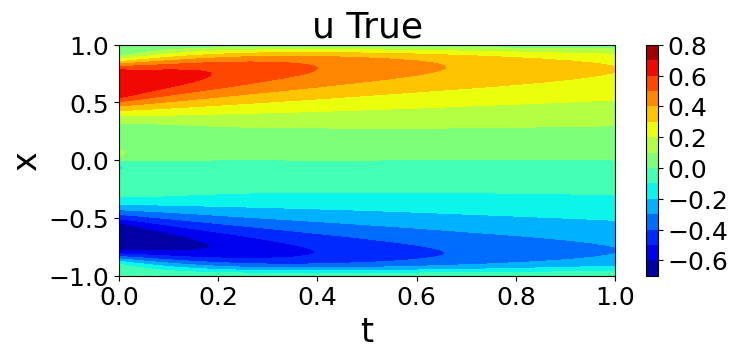

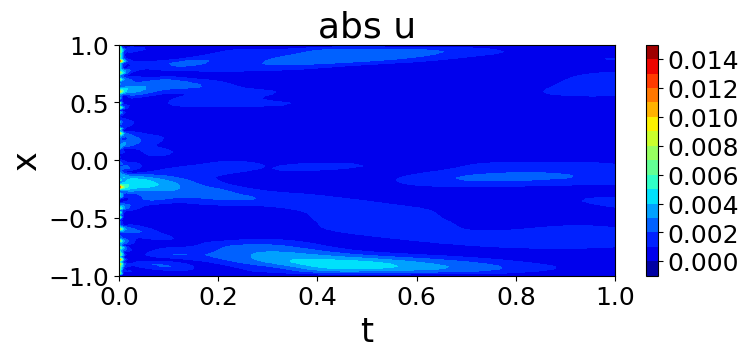

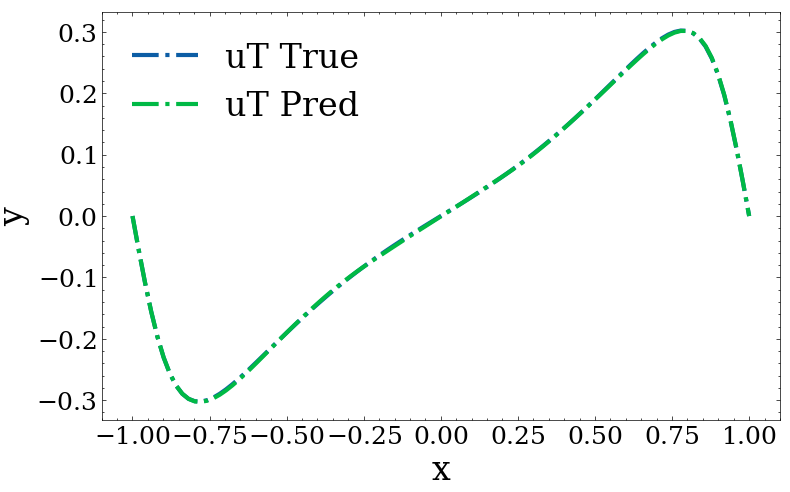

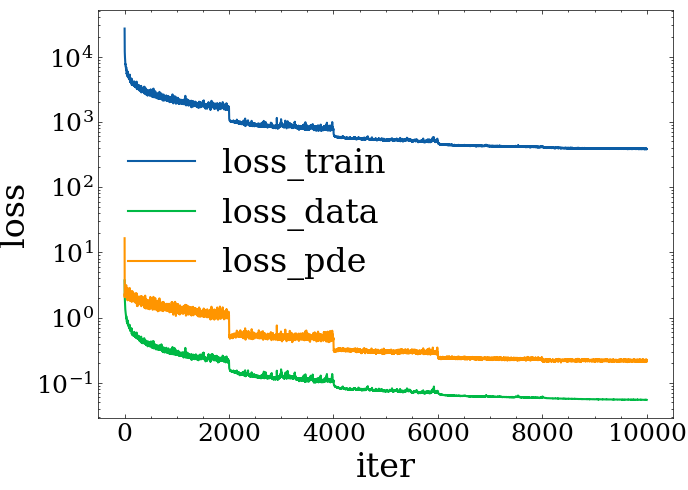

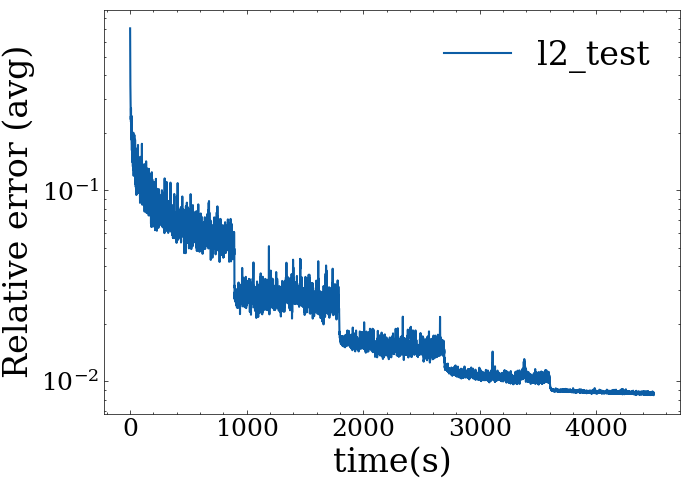

In [3]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
tag = 'tanhBeta64'
model_trained = solver.loadModel(path=f'saved_models/DGNO_{tag}/', name=f'model_dgno_final')
########################################
beta_pred = model_trained['enc'](a_test.to(device))
########################################
xt_test = gridxt_test.repeat(u_test.shape[0], 1, 1).to(device)
u_pred = model_trained['u'](xt_test, beta_pred)
u_pred = mollifer()(u_pred, xt_test).detach().cpu()
#########################################
xt_end_test = xt_end.repeat(uT_test.shape[0], 1, 1).to(device)
uT_pred = model_trained['u'](xt_end_test, beta_pred)
uT_pred = mollifer()(uT_pred, xt_end_test).detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of u_pred:', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
# # # ########################################
from Utils.PlotFigure import Plot
inx = 5
Plot.show_1dt(gridxt_test, u_pred[inx], title='u True', tT=1.)
Plot.show_1dt(gridxt_test, torch.abs(u_pred[inx]-u_test[inx]), title='abs u', tT=1.)
Plot.show_1d_list(x_test[inx], [uT_test[inx], uT_pred[inx]], ['uT True', 'uT Pred'], lb=-1.)
# #############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_{tag}/', name='loss_dgno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])